In [2]:
import os
import sys
import importlib
from contextlib import redirect_stdout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import seaborn as sns
# Apply the default theme
sns.set_theme()
# Set default figure size globally
plt.rcParams['figure.figsize'] = [12, 6]
# sys.path.append(os.path.abspath('../Libraries'))
import volpe_library_2 as vl2 # type: ignore
# Forcing the reload of vl2 without the need of a jp kernel restart
with redirect_stdout(open(os.devnull, 'w')):
    importlib.reload(vl2)

In [3]:
# General parameters
verbose = True
n_params_fit_func = 4           # Nr of parameters of the fitting function for the peak (e.g. EMG)
bin_size = 10e-9                # Size of the bin, in seconds
t0_offset = 1e-5                # Temporal offset
plot_offset = 1e-3

In [4]:
# Dataframe creation
runlist = [427000+x for x in [300, 302, 304, 306, 307, 308, 309]]
# base_df , _ = vl2.tof_load_df(runlist, 'C:\\Users\\marco\\experimental_raw_data\\HCI\\Databases', load_helper=False)
base_df = vl2.tof_df_creation(runlist, 'C:\\ALPACA\\analysis\\volpe\\Databases')

Loading the dataframe from the parquet file...
Dataframe correctly loaded!


                values    errors
5.000000e-09  0.001133  0.000147
1.500000e-08  0.000744  0.000188
2.500000e-08  0.000584  0.000252
3.500000e-08  0.000847  0.000386
4.500000e-08  0.000875  0.000292
...                ...       ...
8.995500e-05  0.001001  0.000277
8.996500e-05  0.000801  0.000275
8.997500e-05  0.000773  0.000185
8.998500e-05  0.000904  0.000261
8.999500e-05  0.000999  0.000175

[9000 rows x 2 columns]
mean error:	0.00021321990162326222
std of errors:	0.0001068272836979243


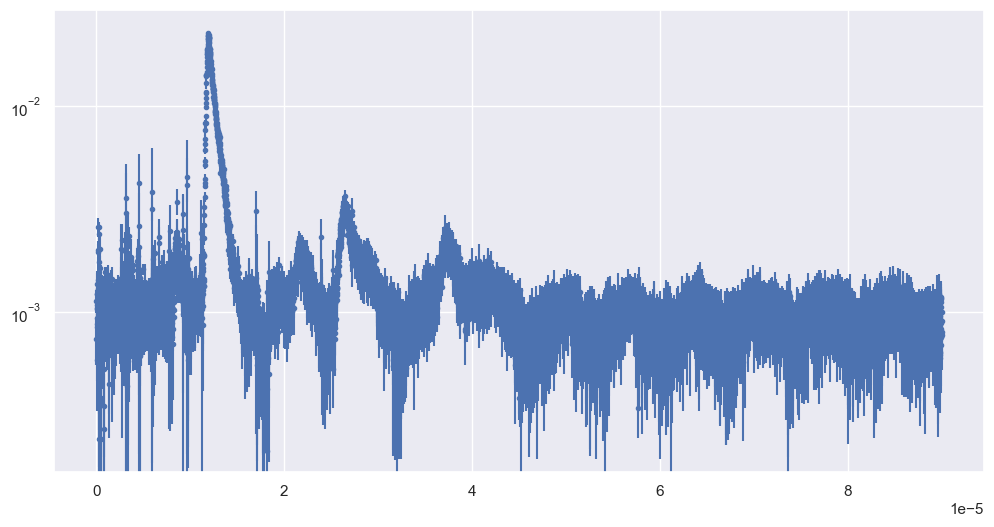

In [5]:
# Dataframe manipulation
df = vl2.massage_df(base_df, bin_size, t0_offset)
# Add a little known offset to plot in log scale
df['values'] += plot_offset

if verbose:
    print(df)
    # print(df[abs((df['errors'] - df['abs_err']))>0])
    # print(f'mean value:\t{df["values"].mean()}')
    print(f'mean error:\t{df["errors"].mean()}')
    print(f'std of errors:\t{df["errors"].std()}')
    # Let's try to plot the various graphs
    # sns.relplot(data=df[(base_df.index.values > 2e-5) & (base_df.index.values < 3e-5)], kind="line")
    # sns.relplot(data=df, kind="scatter")
    # plt.figure(figsize=(12, 6))
    plt.errorbar(df.index, df['values'], yerr=df['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # plt.xscale('log')
    # plt.yscale('symlog', linthresh=1e-4)

Ampl:	0.0004262056960067334
freq:	142894.372133889
phi:	0.9534770885636072
offset:	0.0009167192899575378
exp_tau:	5.6436396929079665e-05
Condition number of the covariance matrix: 9.025963e+16
Diagonal values of pcov:
Cov of Ampl:	3.983786421216892e-09
Cov of freq:	118972.87304069324
Cov of phi:	0.020737864829255798
Cov of offset:	4.781114186018742e-12
Cov of exp_tau:	5.0751927206984804e-11
Chi-2: 3139.69341915968
dof:	3995
Reduced Chi^2:	0.7859057369611214
Goodness-of-Fit:	1.0
R-squared: 0.28718899992123026


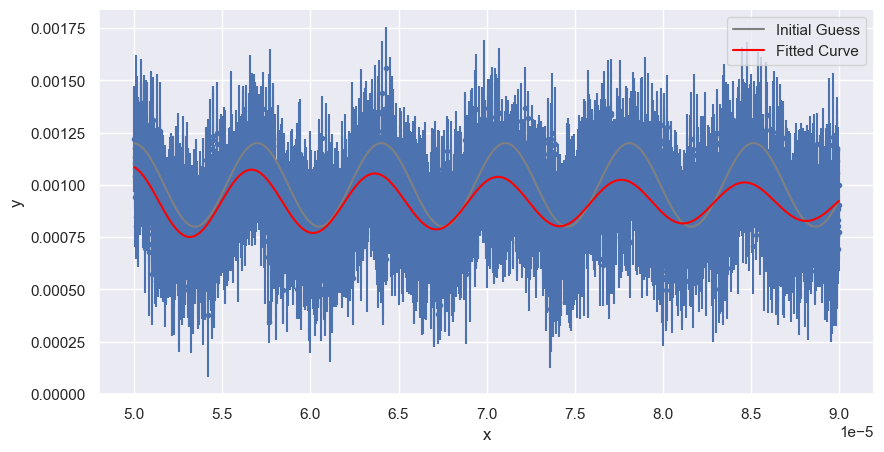

In [6]:
# Let's fit and remove the final oscillation
df_osc = df[(df.index > 5e-5)] # & (df.index <0.0001)]
# Function to fir the oscillation
def oscillation(x, Ampl, freq, phi, offset, exp_tau):
    return Ampl*np.sin(2*np.pi*freq*x+phi)*np.exp(-x/exp_tau) + offset #+exp_ampl*np.exp(-x/exp_tau) 
# Initial parameters array
par_i = [2e-04, 1.42e+05, 1, plot_offset, 1e-1]
# Perform the fit
osc_popt, osc_pcov = vl2.fit_n_plot_errors(df_osc, oscillation, par_i, ['Ampl', 'freq', 'phi', 'offset', 'exp_tau'], verbose=verbose)

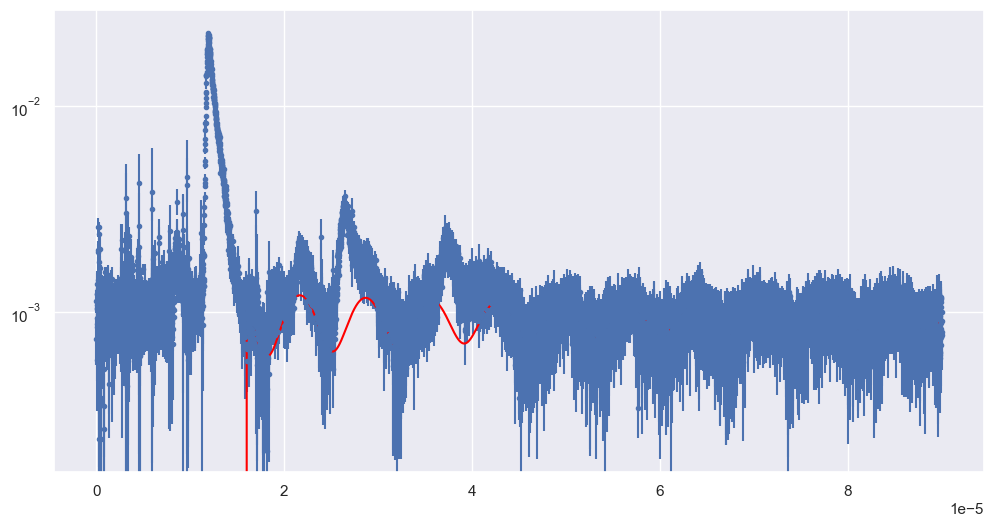

In [7]:
#Let's plot it on the full graph
start_oscillation = 1.6e-5
def cut_oscillation(x, osc_params):
    return np.heaviside(x-start_oscillation, 0)*oscillation(x, *osc_params)
if verbose:
    plt.errorbar(df.index, df['values'], yerr=df['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    plt.plot(df.index.values, cut_oscillation(df.index.values, osc_popt), label='fitted oscillation', color='red')

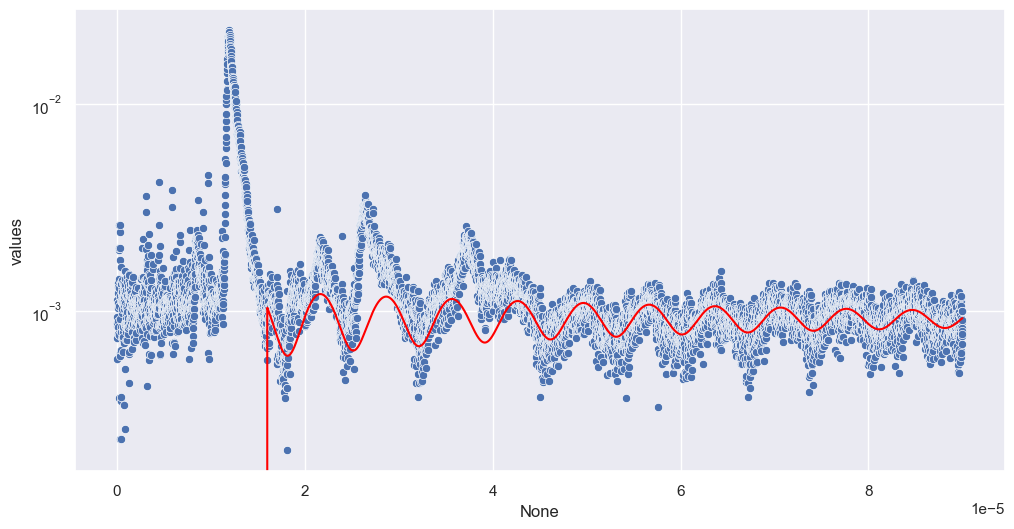

In [8]:
# Plot it with no errors to be more clear
if verbose:    
    # plt.scatter(df.index, df['values'], markersize=3)
    sns.scatterplot(data=df, x=df.index, y='values', sizes=(3,3))
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    plt.plot(df.index.values, cut_oscillation(df.index.values, osc_popt), label='fitted oscillation', color='red')

I determined the x starting point for the oscillation by when the first peaks cross again the 0 (which is 10-3 in the above graph).

Height of the biggest peak: 0.022669732934451542


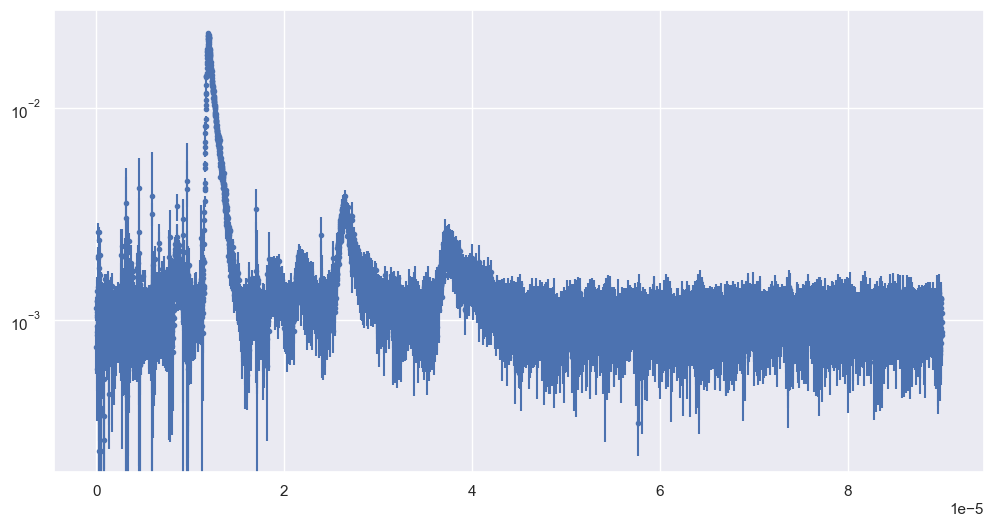

In [9]:
# Unbelievable! Let's remove it and re-plot the function
df2 = df.copy()
df2['values'] -= cut_oscillation(df2.index.values, osc_popt) - np.heaviside(df2.index.values-start_oscillation,0)*plot_offset
if verbose:
    plt.errorbar(df2.index, df2['values'], yerr=df2['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # Customize the ticks on the y-axis
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks at powers of 10
    plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks at intervals between powers of 10
    # plt.gca().yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels
    print(f'Height of the biggest peak: {max(df2["values"])}')

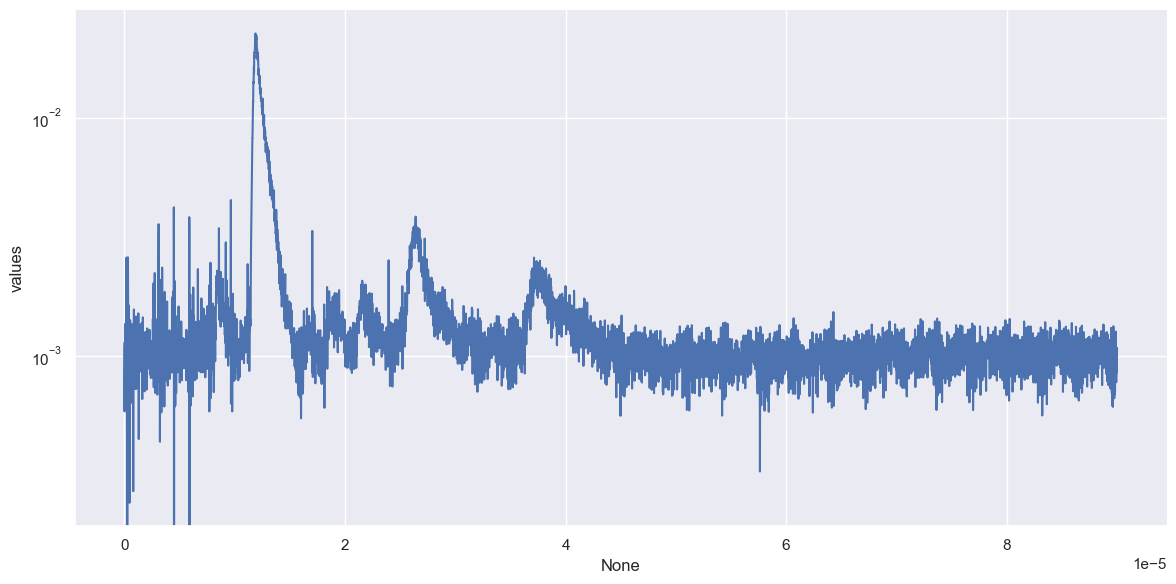

In [10]:
if verbose:
    sns.relplot(data=df2,x=df2.index,y='values', kind='line', height=6, aspect=2)
    plt.yscale('log')
    plt.show()

The maximum of the bigger peak is ~ 2e-2, and generates an oscillation of 4e-4, which is 2 OoM smaller.
Hence, the second biggest peak (around t = 0.000035), which is ~ 3e-3, should generate and oscillation of ~ 6e-5.
Maybe I can neglect it for the time being (but in the future I coud try to generate a similar waveform and subtract it).

Ampl:	2.23483427399993e-08
mu:	1.1695179090086532e-05
sigma:	1.3537799133528246e-07
lam:	1224232.233152662
Condition number of the covariance matrix: 9.291211e+27
Diagonal values of pcov:
Cov of Ampl:	7.22846721743548e-21
Cov of mu:	3.381191587447741e-18
Cov of sigma:	3.671101445759396e-18
Cov of lam:	59091054.75548395
Chi-2: 1731.8872252295473
dof:	596
Reduced Chi^2:	2.9058510490428646
Goodness-of-Fit:	0.0
R-squared: 0.9934341865602331


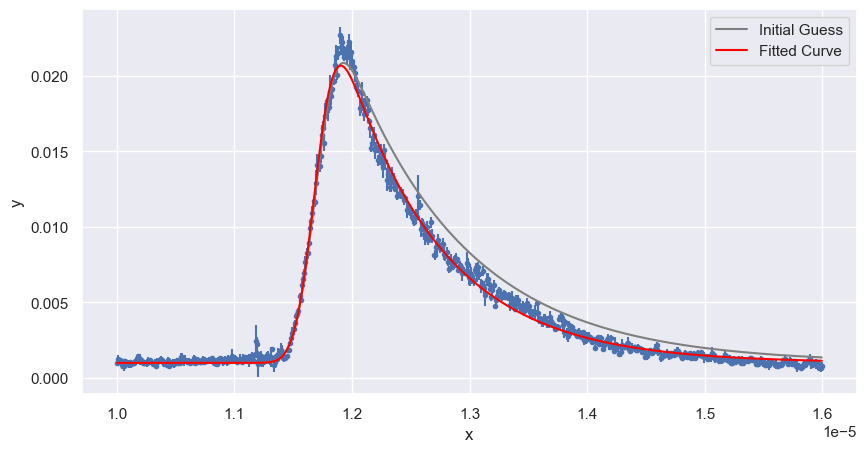

In [11]:
# OK, let's try to fit the peaks: start from biggest, with EMG2
# peaks, peaks_props = find_peaks(df2['values'], height=1e-3)
# peaks = find_peaks_cwt(df2['values'], [1e-6, 2e-6, 5e-6])
def peak_fit_func(x, ampl, mu, sigma, lam):
    return vl2.EMG2(x, ampl, mu, sigma, lam) + plot_offset

df_test = df2[(df2.index > 1e-5) & (df2.index < 1.6e-5)]
par_test_i = [2.65e-8, 1.17e-5, 1.4e-7, 1e6]
test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func, par_test_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose)

In [12]:
# Let's try with exponnorm
if False:
    # Roughly it corresponds to:
    # loc = mu
    # scale = sigma
    # K = 1/(sigma * lam)
    def peak_fit_func2(x, ampl, loc, scale, K):
        return vl2.EMG_exponnorm(x, ampl, loc, scale, K) + plot_offset

    df_test = df2[(df2.index > 1e-5) & (df2.index < 1.6e-5)]
    par_test_i = [2.65e-8, 1.17e-5, 1.4e-7, 7]
    test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func2, par_test_i, ['ampl', 'loc', 'scale', 'K'])

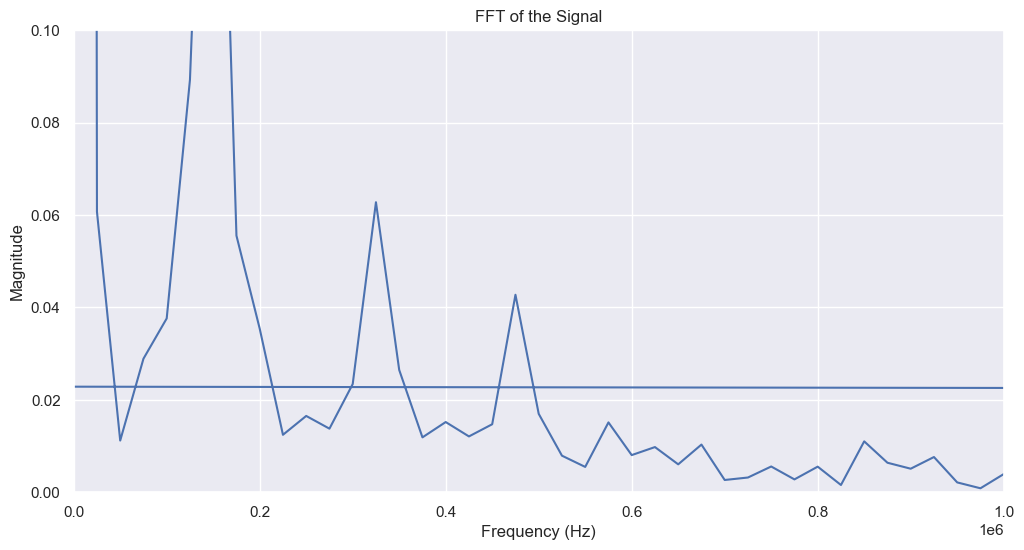

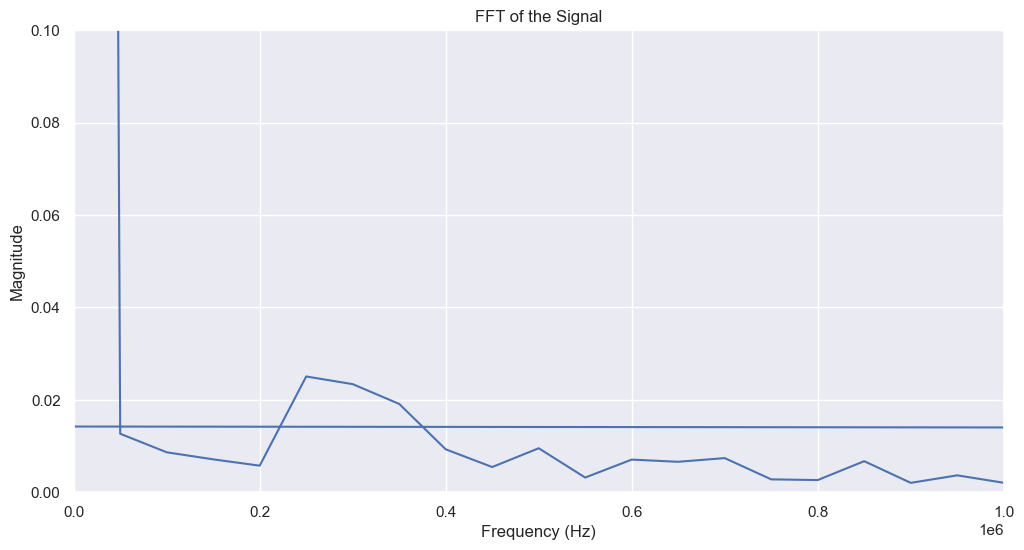

In [13]:
# Extract the further oscillation performing a FFT
if True:
    # Only on the tail of the function (i.e. df_osc)
    # Step 1: Extract the time points and values
    df_osc2 = df_osc #df2[(df2.index > 8e-5) & (df2.index < 10e-5)]
    # time = df_osc2.index.values  # Time points from the index
    values = df_osc2['values'].values  # Signal values
    # Step 2: Calculate the time spacing (delta_t)
    delta_t = bin_size #np.mean(np.diff(time))  # Time difference between consecutive points (assuming uniform sampling)
    # Step 3: Perform the FFT on the 'values' column
    fft_values = np.fft.fft(values)
    # Step 4: Compute the frequency axis
    frequencies = np.fft.fftfreq(len(values), delta_t)
    # Step 5 (Optional): Compute the magnitude of the FFT (since the result is complex)
    magnitude = np.abs(fft_values)
    # Plot the FFT result (frequency spectrum)
    plt.plot(frequencies, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of the Signal')
    plt.xlim(0e5, 10e5)
    plt.ylim(0,0.1)
    plt.grid(True)
    plt.show()

    # Step 1: Extract the time points and values
    df_osc2 = df2[(df2.index > 7e-5)]# & (df2.index < 9e-5)]
    # time = df_osc2.index.values  # Time points from the index
    values = df_osc2['values'].values  # Signal values
    # Step 2: Calculate the time spacing (delta_t)
    delta_t = bin_size #np.mean(np.diff(time))  # Time difference between consecutive points (assuming uniform sampling)
    # Step 3: Perform the FFT on the 'values' column
    fft_values = np.fft.fft(values)
    # Step 4: Compute the frequency axis
    frequencies = np.fft.fftfreq(len(values), delta_t)
    # Step 5 (Optional): Compute the magnitude of the FFT (since the result is complex)
    magnitude = np.abs(fft_values)
    # Plot the FFT result (frequency spectrum)
    plt.plot(frequencies, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of the Signal')
    plt.xlim(0e5, 1e6)
    plt.ylim(0,0.1)
    plt.grid(True)
    plt.show()

In [14]:
# Let's look for a second oscillation 
if False:
    # df_zoom = df2[(df2.index > 8e-5) & (df2.index < 10e-5)]
    # plt.figure(figsize=(12, 6))
    # plt.errorbar(df_zoom.index, df_zoom['values'], yerr=df_zoom['errors'], fmt='.')#, markersize=3)
    # # plt.yscale('log')

    df_osc2 = df2[(df2.index > 5e-5)]# & (df2.index < 10e-5)]
    par_osc2_i = [5e-05, 3e+05, 3, plot_offset, 1e-1]
    # Perform the fit
    osc2_popt, osc2_pcov = vl2.fit_n_plot_errors(df_osc2, oscillation, par_osc2_i, ['Ampl', 'freq', 'phi', 'offset', 'exp_tau'])

In [15]:
# Let's plot the second oscillation on the full graph
if False:
    df2_cut = df2[(df2.index > 3e-5) & (df2.index < 5e-5)]
    plt.figure(figsize=(12, 6))
    plt.errorbar(df2_cut.index, df2_cut['values'], yerr=df2_cut['errors'], fmt='.')#, markersize=3)
    plt.yscale('log')
    # x_fit = np.linspace(min(df.index.values), max(df.index.values), 1000)
    # x_fit = np.linspace(0.000026, max(df.index.values), 1000)
    def cut_osc(x):
        return np.heaviside(x-start_oscillation, 0)*oscillation(x, *osc2_popt)
    plt.plot(df2_cut.index.values, cut_osc(df2_cut.index.values), label='fitted oscillation', color='red')

Ampl:	1.0646434070044695e-09
mu:	8.316345653882483e-06
sigma:	8.312307020682447e-08
lam:	1343583.0888181725
Condition number of the covariance matrix: 9.513313e+30
Diagonal values of pcov:
Cov of Ampl:	2.5291530355629375e-21
Cov of mu:	1.0738196983170686e-16
Cov of sigma:	1.483391299867295e-16
Cov of lam:	12540260534.277065
Chi-2: 363.55805849861855
dof:	296
Reduced Chi^2:	1.2282366841169545
Goodness-of-Fit:	0.00444038227119159
R-squared: 0.3801062056742561


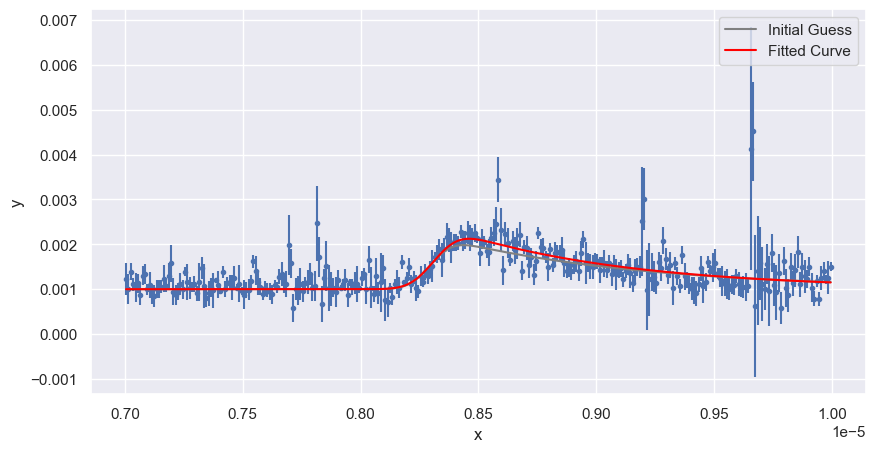

Ampl:	2.2348342951687454e-08
mu:	1.1695179018911214e-05
sigma:	1.3537786220009315e-07
lam:	1224232.0655608138
Condition number of the covariance matrix: 9.291194e+27
Diagonal values of pcov:
Cov of Ampl:	7.228472881899403e-21
Cov of mu:	3.3812399561705082e-18
Cov of sigma:	3.671142518086062e-18
Cov of lam:	59091044.90235935
Chi-2: 1731.8872252270348
dof:	596
Reduced Chi^2:	2.905851049038649
Goodness-of-Fit:	0.0
R-squared: 0.9934341844131538


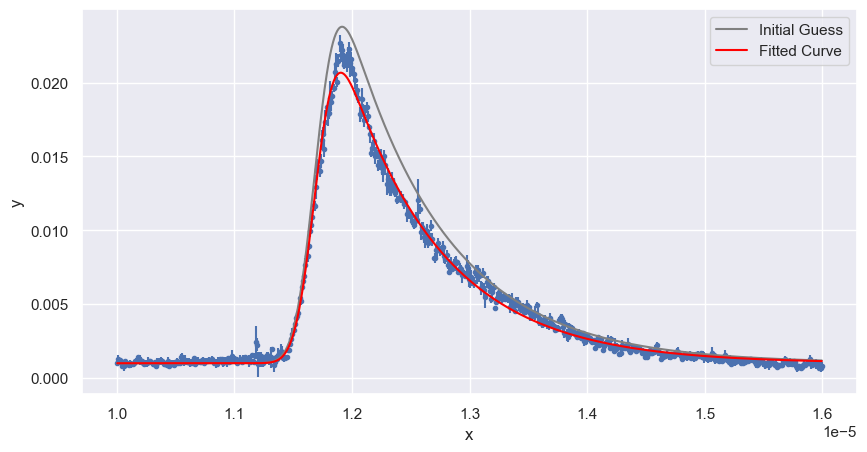

Ampl:	2.195821118679906e-10
mu:	1.6899762744269158e-05
sigma:	3.108957611793357e-07
lam:	112280714.9239983
Condition number of the covariance matrix: inf
Diagonal values of pcov:
Cov of Ampl:	4.717447592092396e-22
Cov of mu:	1.1052120945562872e-09
Cov of sigma:	9.071359791283751e-13
Cov of lam:	1.7602270893185467e+23
Chi-2: 195.3541995220515
dof:	196
Reduced Chi^2:	0.9967050996023035
Goodness-of-Fit:	0.49958690150535723
R-squared: 0.20670526284847845


c:\ALPACA\analysis\volpe\volpe_library_2.py:594: RuntimeWarning: overflow encountered in exp
  factor2 = np.exp(factor1 * (2 * mu + lam * sigma**2 - 2 * x))
c:\ALPACA\analysis\volpe\volpe_library_2.py:596: RuntimeWarning: invalid value encountered in multiply
  total = ampl * factor1 * factor2 * factor3
c:\Users\jzielins\anaconda3\envs\alpaca\lib\site-packages\scipy\optimize\_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


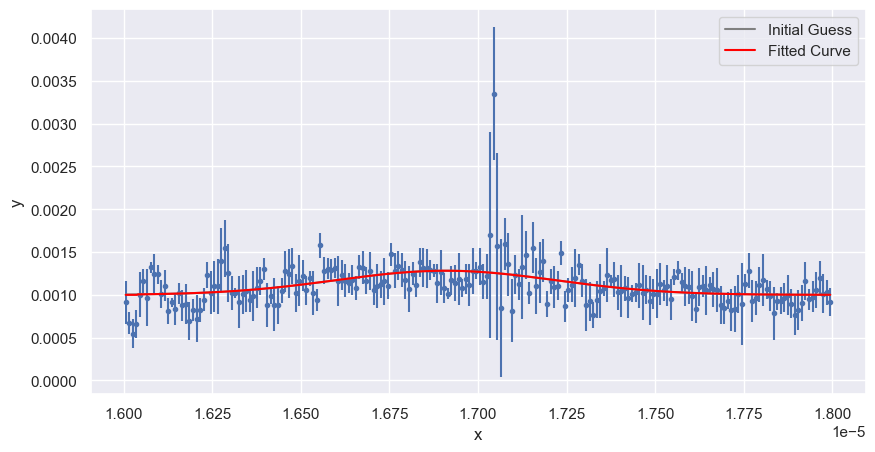

Ampl:	1.1056502159895318e-09
mu:	1.8400183845300508e-05
sigma:	2.782255189949807e-07
lam:	724877.4658020999
Condition number of the covariance matrix: 7.591354e+30
Diagonal values of pcov:
Cov of Ampl:	1.3840591886871943e-20
Cov of mu:	1.8323473971875803e-15
Cov of sigma:	2.7411677009816036e-15
Cov of lam:	25492127851.98198
Chi-2: 270.61697662306483
dof:	196
Reduced Chi^2:	1.3806988603217594
Goodness-of-Fit:	0.0003277610508786166
R-squared: 0.41296028381525074


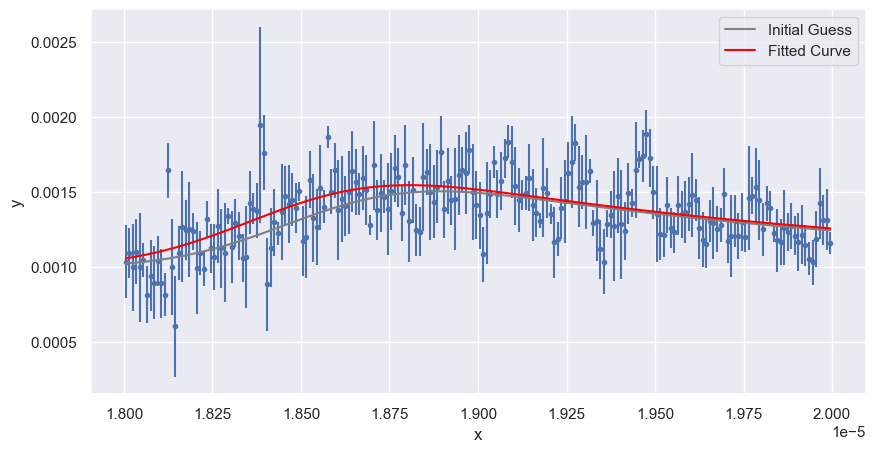

Ampl:	1.153010602460929e-09
mu:	2.116486098119431e-05
sigma:	3.1388330208168597e-07
lam:	854346.9213846758
Condition number of the covariance matrix: 6.222110e+30
Diagonal values of pcov:
Cov of Ampl:	1.7090088491328584e-21
Cov of mu:	6.85603993486301e-16
Cov of sigma:	9.440969326600507e-16
Cov of lam:	4680335968.8059225
Chi-2: 352.19780421445455
dof:	396
Reduced Chi^2:	0.8893883944809459
Goodness-of-Fit:	0.944523693374118
R-squared: 0.51462357550213


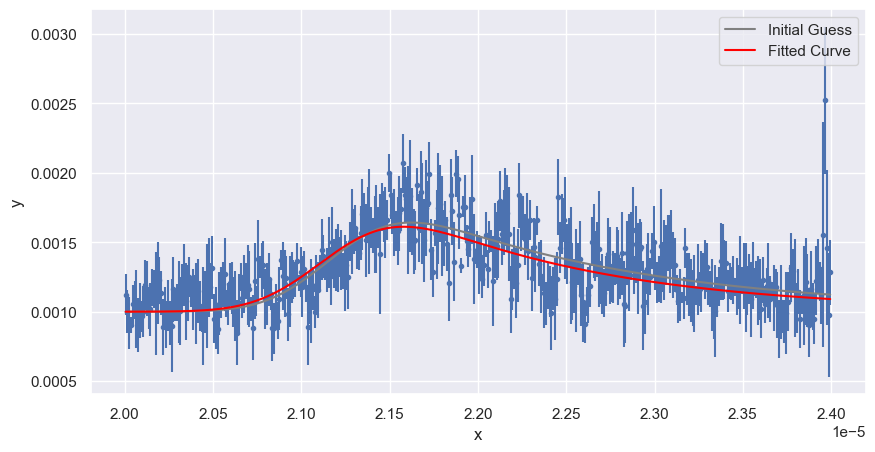

Ampl:	4.7540263502022134e-09
mu:	2.5866478814819126e-05
sigma:	3.102736473458217e-07
lam:	719708.4583411232
Condition number of the covariance matrix: 2.723664e+29
Diagonal values of pcov:
Cov of Ampl:	3.5425060230372795e-21
Cov of mu:	9.872850177693993e-17
Cov of sigma:	1.3438268870531464e-16
Cov of lam:	331296876.73530555
Chi-2: 1159.6467760303844
dof:	596
Reduced Chi^2:	1.9457160671650746
Goodness-of-Fit:	0.0
R-squared: 0.8870968604292956


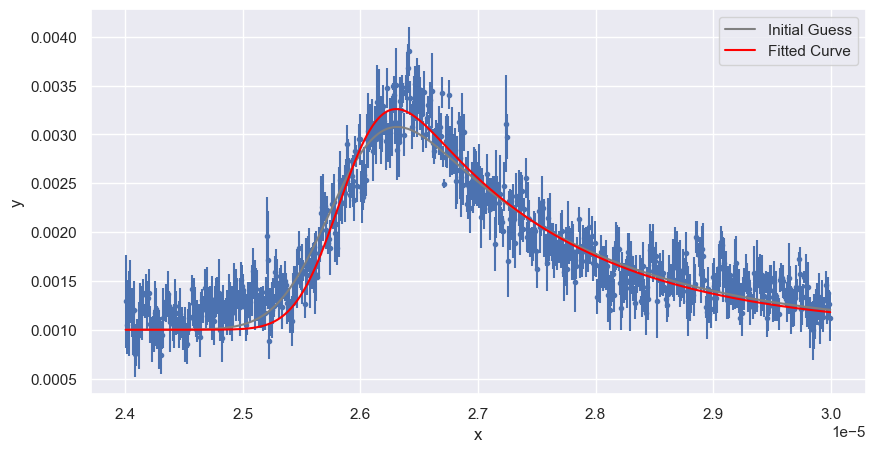

Ampl:	4.014585175470848e-09
mu:	3.672075126021273e-05
sigma:	4.850832224869804e-07
lam:	410420.84602430894
Condition number of the covariance matrix: 8.097062e+28
Diagonal values of pcov:
Cov of Ampl:	3.7884360200540205e-21
Cov of mu:	3.937050137123608e-16
Cov of sigma:	6.192706232460342e-16
Cov of lam:	162720496.08331907
Chi-2: 1271.6088067132446
dof:	996
Reduced Chi^2:	1.2767156693908077
Goodness-of-Fit:	6.079019732041502e-09
R-squared: 0.7875679040822772


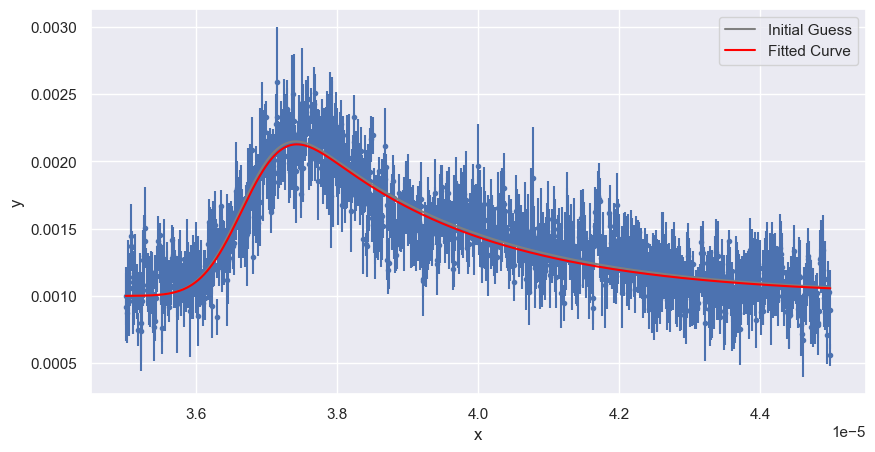

---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.065e-09      8.316e-06      8.312e-08      1.344e+06      
peak_1         2.235e-08      1.170e-05      1.354e-07      1.224e+06      
peak_2         2.196e-10      1.690e-05      3.109e-07      1.123e+08      
peak_3         1.106e-09      1.840e-05      2.782e-07      7.249e+05      
peak_4         1.153e-09      2.116e-05      3.139e-07      8.543e+05      
peak_5         4.754e-09      2.587e-05      3.103e-07      7.197e+05      
peak_6         4.015e-09      3.672e-05      4.851e-07      4.104e+05      
------------------------------------------------------------


In [16]:
# Now let's do it serially! Peak by peak

multi_par_i = [[1e-9,   0.83e-5,    7.4e-8,     1.2e6],
            [2.65e-8,   1.17e-5,    1.4e-7,     1.2e6],
            [2.2e-10,   1.69e-5,    3.1e-7,     1.1e8],
            [9.8e-10,   1.85e-5,    2.7e-7,     7.6e5],
            [1.3e-9,    2.12e-5,    3.0e-7,     7.5e5],
            [4.9e-9,    2.58e-5,    3.8e-7,     6.7e5],
            [4.2e-9,    3.67e-5,    4.8e-7,     3.94e5]]

boundaries = [[0.7e-5,  1.0e-5],
            [1e-5,      1.6e-5],
            [1.6e-5,    1.8e-5],
            [1.8e-5,    2.0e-5],
            [2e-5,      2.4e-5],
            [2.4e-5,    3.0e-5],
            [3.5e-5,    4.5e-5]]

n_peaks = 7
multi_popt = np.zeros((n_peaks,n_params_fit_func))
multi_pcov = np.zeros((n_peaks,n_params_fit_func,n_params_fit_func))
# Peak by peak, serially
for i in range(0,n_peaks):
    df_temp = df2[(df2.index > boundaries[i][0]) & (df2.index < boundaries[i][1])]
    multi_popt[i], multi_pcov[i] = vl2.fit_n_plot_errors(df_temp, peak_fit_func, multi_par_i[i], ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose)
# Let's print the resulting fitting parameters
vl2.print_ToF_details(multi_popt.flatten(), row_headers=[f'peak_{i}' for i in range(n_peaks)])

Ampl:	2.0403809060672578e-10
mu:	1.6890892700041973e-05
sigma:	3.737463302209094e-07
offset_3p:	-1.0061834451473685e-07
Condition number of the covariance matrix: 7.869793e+09
Diagonal values of pcov:
Cov of Ampl:	1.0759669681404494e-23
Cov of mu:	4.917109621387975e-17
Cov of sigma:	4.3223249051053816e-17
Cov of offset_3p:	5.81974637343082e-14
Chi-2: 188.1291241699956
dof:	8996
Reduced Chi^2:	0.020912530476878126
Goodness-of-Fit:	1.0
R-squared: 0.3104880838839652


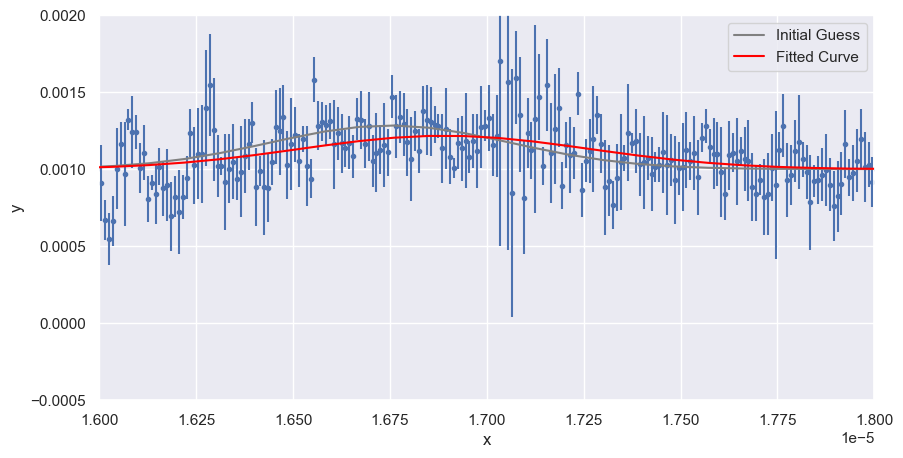

In [17]:
# Fixing third peak
df_3p = df2.copy()
# df_3p = df_3p[(df_3p.index > boundaries[2][0]) & (df_3p.index < boundaries[2][1])]
df_3p.loc[df_3p.index < 1.6e-5, 'values'] = plot_offset
df_3p.loc[df_3p.index > 1.8e-5, 'values'] = plot_offset
# Third peak fitting function
def third_peak_fit_func(x, ampl, mu, sigma, offset_3p):
    return vl2.Gauss(x, ampl, mu, sigma) + plot_offset + offset_3p
# Initial paramters
par_3p_i = [2.2e-10,   1.675e-5,    3.1e-7, 1e-6]
# plt.figure(figsize=(10, 5))
# plt.errorbar(df_3p.index, df_3p.iloc[:,0].values, yerr=df_3p.iloc[:,1].values, fmt='.')#, markersize=3)
# plt.plot(df_3p.index, third_peak_fit_func(df_3p.index, *par_3p_i), label='Initial Guess', color='grey')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.yscale('log')
# # plt.legend()
# plt.show()
popt_3p, pcov_3p = vl2.fit_n_plot_errors(df_3p, third_peak_fit_func, par_3p_i, ['Ampl', 'mu', 'sigma', 'offset_3p'], verbose=True, maxfev=100000, xlim=(1.6e-5,1.8e-5), ylim=(-0.0005, 0.002))

offset_3p:	2.01780446651972e-06
Condition number of the covariance matrix: 1.000000e+00
Diagonal values of pcov:
Cov of offset_3p:	9.204387016277154e-14
Chi-2: 304.20798950805363
dof:	8999
Reduced Chi^2:	0.03380464379464981
Goodness-of-Fit:	1.0
R-squared: -7.905659741425097e-05


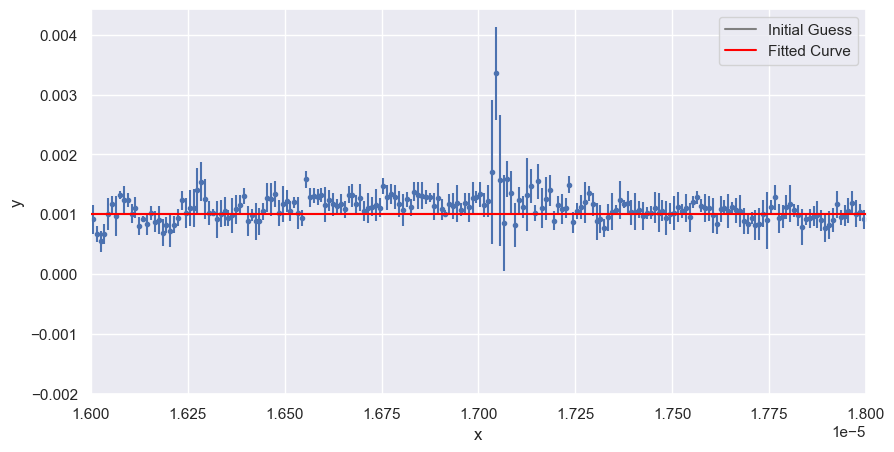

In [18]:
# And if we fit a constant?
df_3p_2 = df2.copy()
# df_3p = df_3p[(df_3p.index > boundaries[2][0]) & (df_3p.index < boundaries[2][1])]
df_3p_2.loc[df_3p_2.index < 1.6e-5, 'values'] = plot_offset
df_3p_2.loc[df_3p_2.index > 1.8e-5, 'values'] = plot_offset
# Third peak fitting function
def third_peak_fit_func(x, offset_3p):
    return np.full(len(x), plot_offset + offset_3p)
# Initial paramters
par_3p_2_i = [1e-6]
# plt.figure(figsize=(10, 5))
# plt.errorbar(df_3p.index, df_3p.iloc[:,0].values, yerr=df_3p.iloc[:,1].values, fmt='.')#, markersize=3)
# plt.plot(df_3p.index, third_peak_fit_func(df_3p.index, *par_3p_i), label='Initial Guess', color='grey')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.yscale('log')
# # plt.legend()
# plt.show()
popt_3p_2, pcov_3p_2 = vl2.fit_n_plot_errors(df_3p_2, third_peak_fit_func, par_3p_2_i, ['offset_3p'], verbose=True, maxfev=100000, xlim=(1.6e-5,1.8e-5))

[1.06464341e-09 8.31634565e-06 8.31230702e-08 1.34358309e+06
 2.23483430e-08 1.16951790e-05 1.35377862e-07 1.22423207e+06
 1.10565022e-09 1.84001838e-05 2.78225519e-07 7.24877466e+05
 1.15301060e-09 2.11648610e-05 3.13883302e-07 8.54346921e+05
 4.75402635e-09 2.58664788e-05 3.10273647e-07 7.19708458e+05
 4.01458518e-09 3.67207513e-05 4.85083222e-07 4.10420846e+05
 2.04038091e-10 1.68908927e-05 3.73746330e-07]


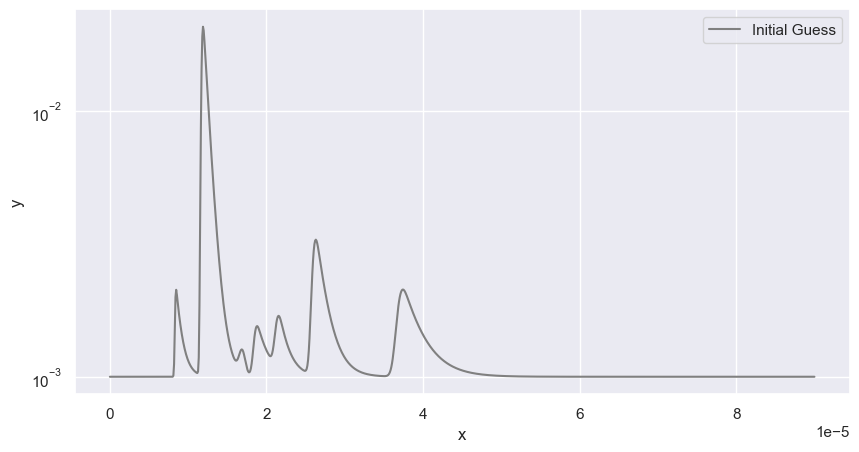

Ampl:	1.1106489343347412e-09
mu:	8.311425113761229e-06
sigma:	7.778189523315515e-08
lam:	1225845.901279942
Condition number of the covariance matrix: 3.681990e+32
Diagonal values of pcov:
Cov of Ampl:	1.7293905230757967e-21
Cov of mu:	9.192750298015254e-17
Cov of sigma:	1.4210390099901414e-16
Cov of lam:	5363894930.709592
Chi-2: 11028.29300834766
dof:	8973
Reduced Chi^2:	1.2290530489632967
Goodness-of-Fit:	0.0
R-squared: 0.9824059946229883


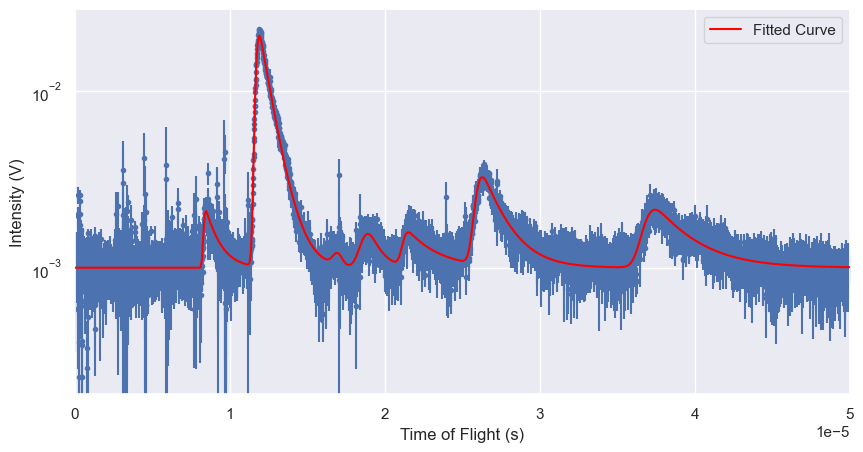

[1.11064893e-09 8.31142511e-06 7.77818952e-08 1.22584590e+06
 2.23142597e-08 1.16956187e-05 1.35005281e-07 1.22573135e+06
 8.56026841e-10 1.85307408e-05 3.75558659e-07 1.37584243e+06
 1.33060102e-09 2.11539884e-05 2.18999461e-07 5.49361235e+05
 4.67170838e-09 2.58726069e-05 2.90333277e-07 6.99045548e+05
 3.98015687e-09 3.67284055e-05 4.87051913e-07 4.18078587e+05
 1.24300781e-10 1.69419035e-05 2.92217410e-07]


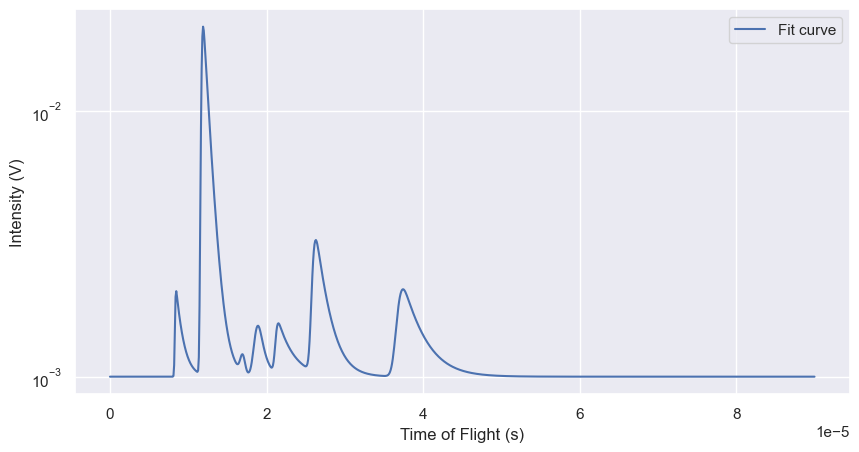

Starting parameters:
---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.065e-09      8.316e-06      8.312e-08      1.344e+06      
peak_1         2.235e-08      1.170e-05      1.354e-07      1.224e+06      
peak_3         1.106e-09      1.840e-05      2.782e-07      7.249e+05      
peak_4         1.153e-09      2.116e-05      3.139e-07      8.543e+05      
peak_5         4.754e-09      2.587e-05      3.103e-07      7.197e+05      
peak_6         4.015e-09      3.672e-05      4.851e-07      4.104e+05      
peak_2         2.040e-10      1.689e-05      3.737e-07      0.000e+00      
------------------------------------------------------------
Fit parameters:
---------------------------------------------------------------------------
               Ampl           mu             sigma          lam            
peak_0         1.111e-09      8.311e-06      7.778e-08      1.226e

In [19]:
# Let's try to fit all the peaks together now
# Starting from the df where the oscillation has been subtracted
df3 = df2 
# Let's remove the third peak completely
multi_popt_wo3rdpeak = np.delete(multi_popt, 2, axis=0)
# Let's build the array of initial parameters, adding the third peak to the end
multifit_par_i = multi_popt_wo3rdpeak.flatten()
multifit_par_i = np.append(multifit_par_i, np.delete(popt_3p,3))
# vl2.print_ToF_details(multifit_par_i)
print(multifit_par_i)

n_peaks = 7 # Since I've removed it before
# Function fitting all peaks
def peak_fit_all(x, *args):
    # Start with the offset
    total = plot_offset 
    # Add the EMG peaks
    n_peaks_internal = 6
    for i in np.arange(n_peaks_internal): 
        total += vl2.EMG2(x, args[n_params_fit_func*i], args[n_params_fit_func*i+1], args[n_params_fit_func*i+2], args[n_params_fit_func*i+3])
        # print(f'params of {i}: {args[n_params_fit_func*i]}, {args[n_params_fit_func*i+1]}, {args[n_params_fit_func*i+2]}, {args[n_params_fit_func*i+3]}')
    # Manually add 3rd peak
    third_p_start_index = n_peaks_internal*n_params_fit_func
    total += vl2.Gauss(x, args[third_p_start_index],args[third_p_start_index+1],args[third_p_start_index+2])
    # print(f'Params of 3rd peak: {args[third_p_start_index]},{args[third_p_start_index+1]},{args[third_p_start_index+2]}')
    return total

# Generate the fitted curve
x_fit = np.linspace(min(df3.index.values), max(df3.index.values), 1000)
# Plot the data and the fitted curve
plt.figure(figsize=(10, 5))
# plt.errorbar(df3.index, df3.iloc[:,0].values, yerr=df3.iloc[:,1].values, fmt='.')#, markersize=3)
plt.plot(x_fit, peak_fit_all(x_fit, *multifit_par_i.flatten()), label='Initial Guess', color='grey')
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.legend()
plt.show()

# Fit everything together
popt_tot, pcov_tot = vl2.fit_n_plot_errors_for_paper(df3, peak_fit_all, multifit_par_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=verbose, maxfev= 10000, yscale='log')
print(popt_tot)
row_headers=[f'peak_{i}' for i in np.concatenate((np.arange(0,2), np.arange(3,n_peaks)))] + ['peak_2']
if verbose:
    # Generate the fitted curve
    x_fit = np.linspace(min(df3.index.values), max(df3.index.values), 1000)
    # Plot the data and the fitted curve
    plt.figure(figsize=(10, 5))
    # plt.errorbar(df3.index, df3.iloc[:,0].values, yerr=df3.iloc[:,1].values, fmt='.')#, markersize=3)
    plt.plot(x_fit, peak_fit_all(x_fit, *popt_tot.flatten()), label='Fit curve')
    plt.xlabel('Time of Flight (s)')
    plt.ylabel('Intensity (V)')
    plt.yscale('log')
    plt.legend()
    plt.show()
    print('Starting parameters:')
    vl2.print_ToF_details(np.append(multifit_par_i,[0]), row_headers=row_headers)
print('Fit parameters:')
vl2.print_ToF_details(np.append(popt_tot,[0]), row_headers=row_headers)
print('Percentage variation:')
vl2.print_ToF_details(np.append((100*(multifit_par_i-popt_tot)/popt_tot).astype(int),[0]), row_headers=row_headers)

(1.1e-05, 1.4e-05)

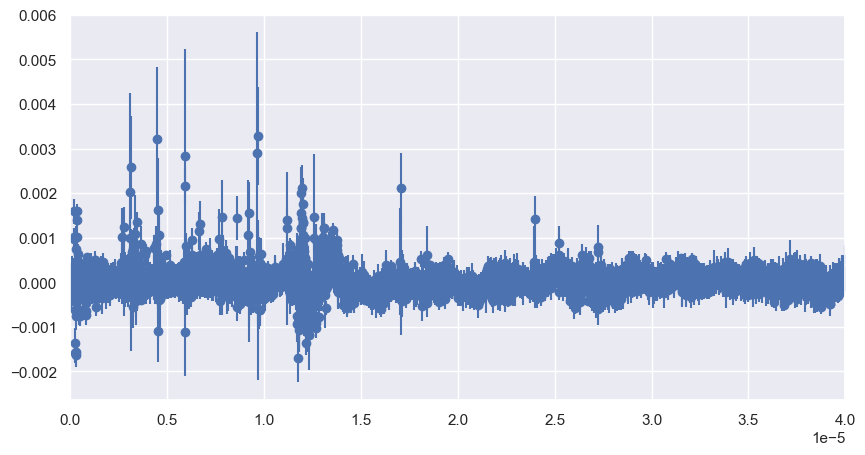

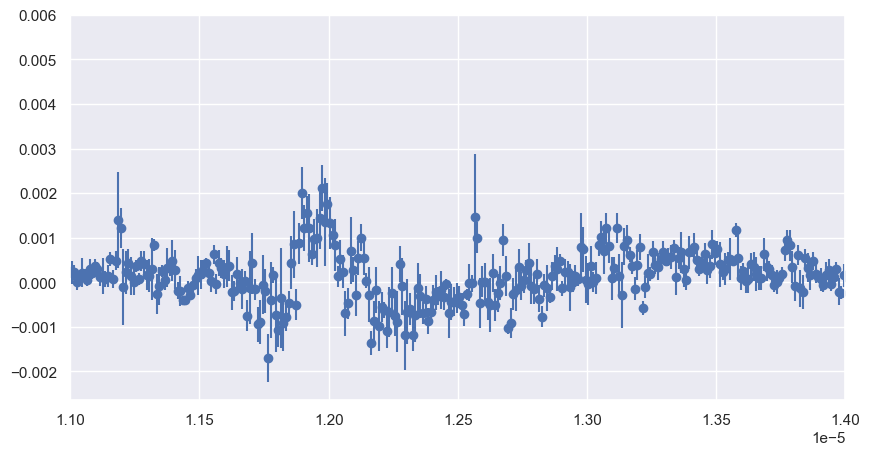

In [20]:
# Residuals estimation
df_residuals = df3.copy()
df_residuals['residuals'] = df_residuals['values'] - peak_fit_all(df_residuals.index, *multifit_par_i)
plt.figure(figsize=(10, 5))
# sns.scatterplot(df_residuals, x=df_residuals.index, y='residuals')
plt.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
plt.xlim(0,4e-5)
plt.figure(figsize=(10, 5))
plt.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
plt.xlim(1.1e-5, 1.4e-5)

In [21]:
import polars as pl

Q=1+ -> m/q=39.96238312204 -> tof=3.733414640772893e-05
Q=2+ -> m/q=19.98119156102 -> tof=2.6399228094716508e-05
Q=3+ -> m/q=13.320794374013333 -> tof=2.1554879478467196e-05
Q=4+ -> m/q=9.99059578051 -> tof=1.8667073203864465e-05
Q=5+ -> m/q=7.992476624408001 -> tof=1.669633784992229e-05
Q=6+ -> m/q=6.660397187006667 -> tof=1.5241601446882907e-05
Q=7+ -> m/q=5.708911874577143 -> tof=1.4110980972246598e-05
Q=8+ -> m/q=4.995297890255 -> tof=1.3199614047358254e-05
Q=9+ -> m/q=4.440264791337778 -> tof=1.2444715469242979e-05
Q=10+ -> m/q=3.9962383122040004 -> tof=1.1806093714661674e-05
Q=11+ -> m/q=3.6329439201854545 -> tof=1.1256668682057434e-05
Q=12+ -> m/q=3.3301985935033334 -> tof=1.0777439739233598e-05
Q=13+ -> m/q=3.074029470926154 -> tof=1.0354629169134333e-05
Q=14+ -> m/q=2.8544559372885714 -> tof=9.97797033466991e-06
Q=15+ -> m/q=2.6641588748026668 -> tof=9.639635152133572e-06
Q=16+ -> m/q=2.4976489451275 -> tof=9.333536601932232e-06
Q=17+ -> m/q=2.3507284189435294 -> tof=9.0548605

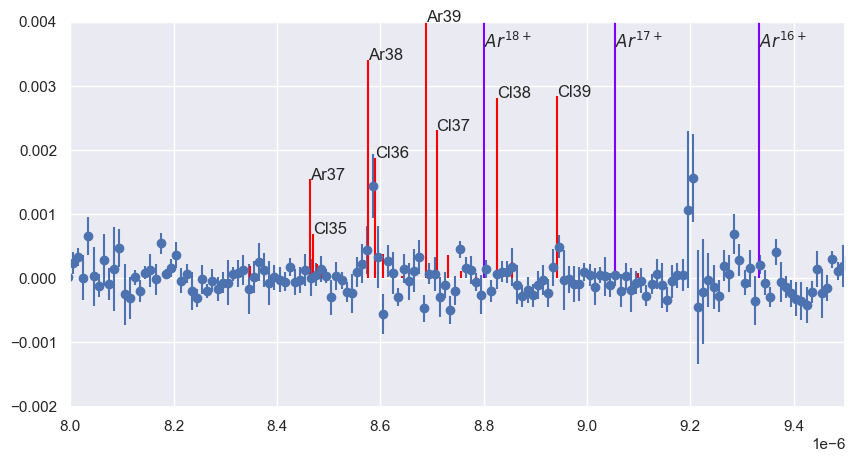

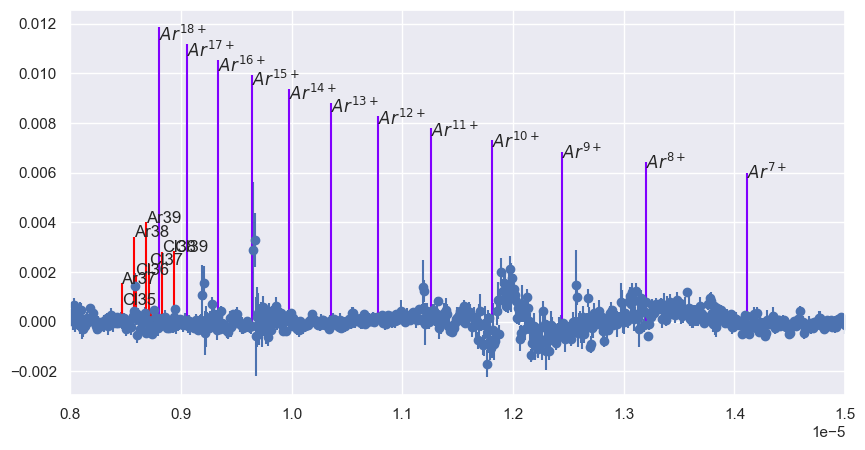

In [22]:
# load simulation data
df_sim = pl.read_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\trappable_Ar40_m-over-q.parquet").sort("tof_exp_s")
id_fragments = tof_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select("fragment")).to_list()
tof_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select("tof_exp_s")).to_list()
count_fragments = pl.Series(df_sim.filter(pl.col("trappable_count").gt(0)).select(pl.col("trappable_count").truediv(pl.col("trappable_count").max()))).to_list()
# print(id_fragments)
# print(tof_fragments)
# print(count_fragments)
# print(df_sim)

# load the mass of Ar40
m_Ar40 = (pl.scan_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\isotopes_info.parquet")
          .filter(pl.col("Z").eq(18),pl.col("N").eq(22))
          .select("atomic_mass")
          .collect()
          .item())


# print(m_Ar40)
q_Ar40 = np.array([q for q in range(1,19)])
mq_Ar40 = np.array([m_Ar40/q for q in q_Ar40])
tof_Ar40 = vl2.tof_from_mq(mq_Ar40)
# print(mq_Ar40)
# print(tof_Ar40)
for q in range(1,19):
    print(f"Q={q}+ -> m/q={m_Ar40/q} -> tof={vl2.tof_from_mq(m_Ar40/q)}")

# Residuals estimation
df_residuals = df3.copy()
df_residuals['residuals'] = df_residuals['values'] - peak_fit_all(df_residuals.index, *multifit_par_i)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
ax.set_xlim(0.8e-5, 0.95e-5)
ax.set_ylim(-0.002,0.004)

# ax.vlines(tof_fragments,0,np.array(count_fragments)*ax.get_ylim()[1],color=(1,0,0))
y_lim = ax.get_ylim()[1]
for i,fragment in enumerate(id_fragments):
    ax.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
    if count_fragments[i] > 0.1:
        ax.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

for i,q in enumerate(q_Ar40):
    if tof_Ar40[i] > ax.get_xlim()[1]:
        continue
    ax.vlines(tof_Ar40[i],0,ax.get_ylim()[1],color=(0.5,0,1))
    ax.text(tof_Ar40[i],0.9*ax.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot()
ax2.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
ax2.set_xlim(0.8e-5, 1.5e-5)
for i,fragment in enumerate(id_fragments):
    ax2.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
    if count_fragments[i] > 0.1:
        ax2.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

for i,q in enumerate(q_Ar40):
    if tof_Ar40[i] > 1.5e-5:
        continue
    ax2.vlines(tof_Ar40[i],0,ax2.get_ylim()[1],color=(0.5,0,1))
    ax2.text(tof_Ar40[i],0.9*ax2.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

# fig3 = plt.figure(figsize=(10, 5))
# ax3 = fig3.add_subplot()
# # ax3.errorbar(x=df_residuals.index,y=df_residuals['residuals'],yerr=df_residuals['errors'], fmt='o')
# ax3.plot(x_fit, peak_fit_all(x_fit, *popt_tot.flatten()), label='Fit curve')
# # ax3.set_xlim(0.8e-5, 1.5e-5)
# for i,fragment in enumerate(id_fragments):
#     ax3.vlines(tof_fragments[i],0,count_fragments[i]*y_lim,color=(1,0,0))
#     if count_fragments[i] > 0.1:
#         ax3.text(tof_fragments[i],count_fragments[i]*y_lim, fragment)

# for i,q in enumerate(q_Ar40):
#     # if tof_Ar40[i] > 1.5e-5:
#     #     continue
#     ax3.vlines(tof_Ar40[i],0,ax2.get_ylim()[1],color=(0.5,0,1))
#     ax3.text(tof_Ar40[i],0.9*ax2.get_ylim()[1], r"$Ar^{"+f"{q}"+r"+}$")

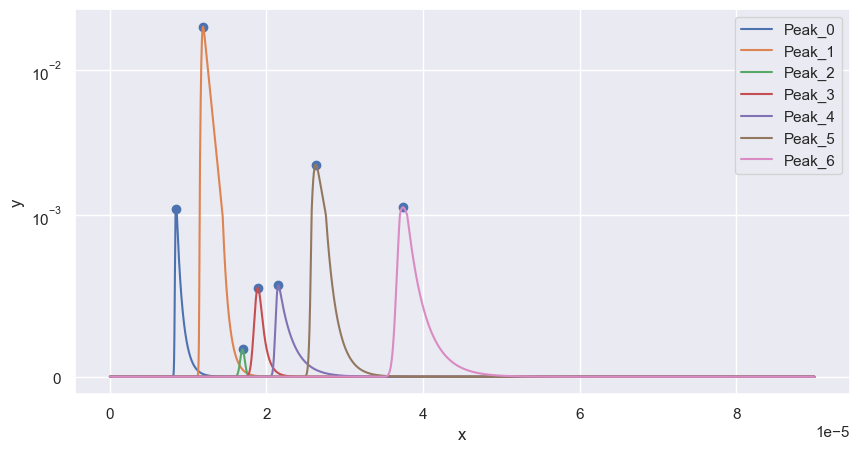

In [23]:
# For each peak, let's now extract raw observables (max height, integral and x_max) from the fitted curve
df4 = df3.copy()
# Create a column for each peak, with the fitted curve values
for i in range(0,2):
    # df4[f'peak_{i}'] = [vl2.EMG2(idx, *popt_tot[(i*n_params_fit_func):((i+1)*n_params_fit_func)]) for idx in df4.index]
    df4[f'peak_{i}'] = df4.index.to_series().apply(lambda idx: vl2.EMG2(idx, *popt_tot[i*n_params_fit_func:(i+1)*n_params_fit_func]))
# Manually change the 3rd peak
df4[f'peak_2'] = df4.index.to_series().apply(lambda idx: vl2.Gauss(idx, *popt_tot[-3:]))
# And the rest of the peaks
for i in range(2,n_peaks-1):
    df4[f'peak_{i+1}'] = df4.index.to_series().apply(lambda idx: vl2.EMG2(idx, *popt_tot[i*n_params_fit_func:(i+1)*n_params_fit_func]))
      
# Create the DataFrame
col_ids = [f'peak_{i}' for i in range(n_peaks)]
df_raw_observables = pd.DataFrame({
    'max_height': df4[col_ids].max().values,
    'integral'  : (bin_size * df4[col_ids].sum()).values,
    't_max'     : df4[col_ids].idxmax().values,
    'mu'        : popt_tot[1::4],
    # 'mean'      : popt_tot[1::4]+1/popt_tot[3::4]
    }, index=col_ids)
df_raw_observables['m/q']       = vl2.mq_from_tof(df_raw_observables['t_max'])
df_raw_observables['m/q_mu']    = vl2.mq_from_tof(df_raw_observables['mu'])
# df_raw_observables['m/q mean']  = vl2.mq_from_tof(df_raw_observables['mean'])
df_raw_observables['m/q std']   = vl2.mq_from_tof(df_raw_observables['t_max'], popt_tot[2::4])[1]
df_raw_observables['t_std']     = popt_tot[2::4]

# Plot the various curves, together with the points of the maximums
if verbose:
    # vl2.print_float_df(df_raw_observables)
    plt.figure(figsize=(10, 5))
    for i in range(n_peaks):
        plt.plot(df4.index, df4[f'peak_{i}'].values, label=f'Peak_{i}')
    plt.scatter(df_raw_observables['t_max'], df_raw_observables['max_height'])
    # plt.scatter(df_raw_observables['mu'], df_raw_observables['max_height'])
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.yscale('log')
    plt.yscale('symlog', linthresh=1e-3)
    # plt.ylim(1e-4, 2.5e-2)
    # # Add vertical red lines for each Ag state
    # for x_val in vl2.argon_m_q:
    #     plt.axvline(x=vl2.tof_from_mq(x_val), color='red', linestyle='--')
    plt.legend()
    plt.show()


       candidate        m/q     m/q_mu   m/q std  m/q cand  intensity
peak_0      He2+   2.049586   1.980569  0.046837    2.0013   0.139523
peak_1      He1+   4.063476   3.921799  0.107363    4.0026   5.606377
peak_2      Ag5+   8.232317   9.845199  0.381588    7.9900   0.006246
peak_3      Ag4+  10.246895  12.829905  0.275041    9.9870   0.053768
peak_4      Ag3+  13.283889  19.191959  0.401035   13.3160   0.111436
peak_5      Ag2+  19.823726  38.676136  0.781978   19.9740   0.586875
peak_6      Ag1+  40.178582   8.229308  0.830657   39.9480   1.000000


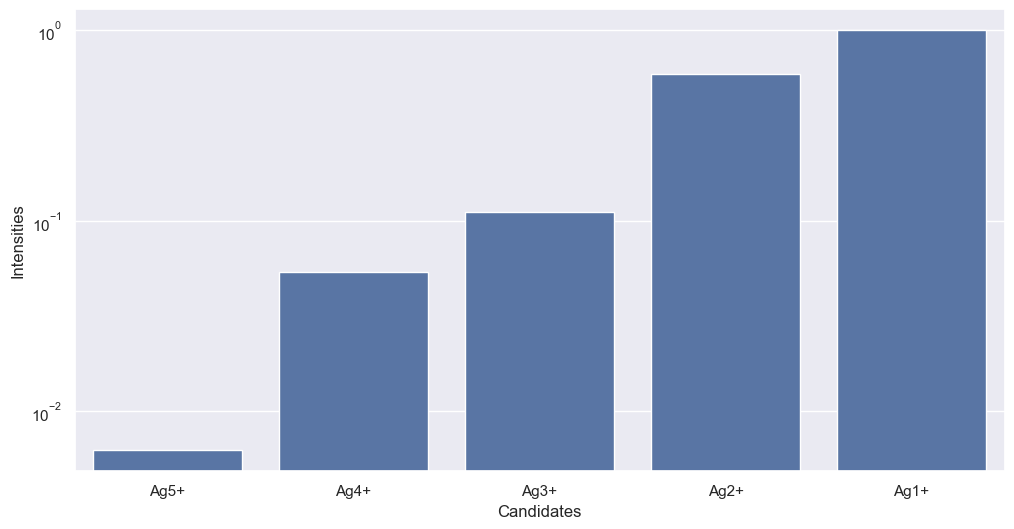

In [24]:
# Let's finalise it
df_obs = pd.DataFrame()
df_obs['m/q']       = df_raw_observables['m/q']
df_obs['m/q_mu']       = df_raw_observables['m/q_mu']
df_obs['m/q std']   = df_raw_observables['m/q std']
df_obs['m/q cand']  = [vl2.helium_mq(2),
                       vl2.helium_mq(1),
                       vl2.argon_mq(5),
                       vl2.argon_mq(4),
                       vl2.argon_mq(3),
                       vl2.argon_mq(2),
                       vl2.argon_mq(1)]
df_obs.insert(0, 'candidate', ['He2+',
                                'He1+',
                                'Ag5+',
                                'Ag4+',
                                'Ag3+',
                                'Ag2+',
                                'Ag1+'])
charges = [2,1,5,4,3,2,1]
df_obs['intensity'] = df_raw_observables['integral']/charges
df_obs['intensity'] = df_obs['intensity']/df_obs['intensity'].iloc[-1]

# print(df_obs.map(lambda x: f'{x:.2f}'))
print(df_obs)
# Bar plot with error bars
sns.barplot(x='candidate', y='intensity', data=df_obs.iloc[2:]) #, yerr=df['errors'])
# Add labels and title
plt.xlabel('Candidates')
plt.ylabel('Intensities')
plt.yscale('log')
# plt.title('Bar Chart with Error Bars')
plt.show()

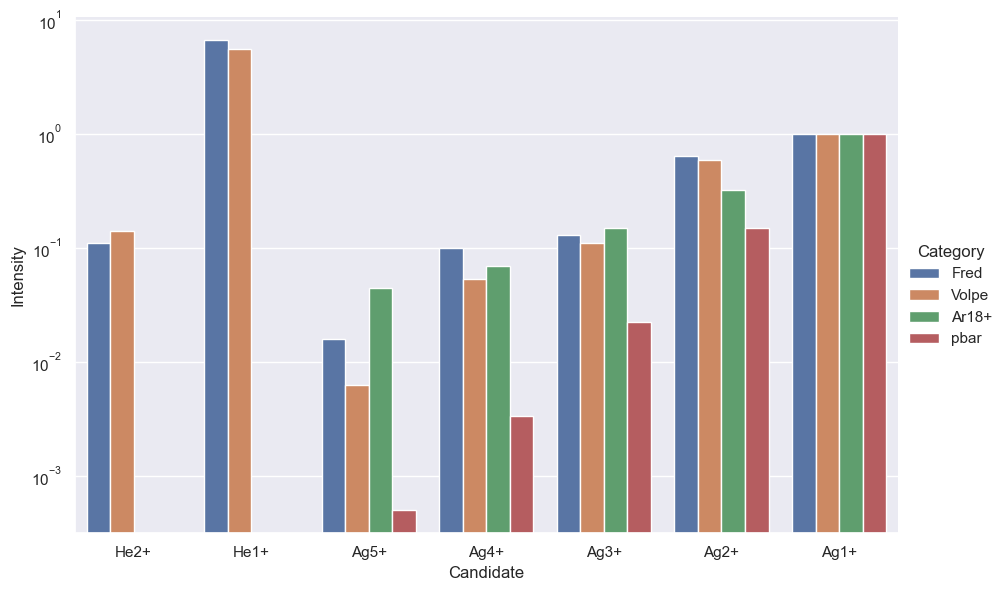

In [25]:
# Plot together Fredrik results
fred_intensities = [0.11,   6.61,   0.016,  0.1,    0.129,  0.637,  1]
ar18_intensities = [x/8.5 for x in [0,      0,      0.376,  0.589,  1.27,   2.76,   8.5]]
pbar_intensities = [x/20 for x in [0,      0,      0.0101, 0.0675,  0.45,   3,      20]]
indices_array = [['Fred']*7 + ['Volpe']*7 + ['Ar18+']*7 + ['pbar']*7,
                 df_obs['candidate'].values.tolist() * 4]

intensities_array = fred_intensities + df_obs['intensity'].values.tolist() + ar18_intensities + pbar_intensities
index = pd.MultiIndex.from_arrays(indices_array, names=('Category', 'Candidate'))
barchart_df = pd.DataFrame({'Intensity': intensities_array}, index=index)

# print(barchart_df)

sns.catplot(data=barchart_df, x='Candidate', y='Intensity', hue='Category', kind='bar', height=6, aspect=1.5)
plt.yscale('log')